# Tweet Sentiment Analysis with BERT

## 1. Fine-Tune BERT For Climate Sentiment Analysis (Uncleaned Data)

In this notebook, we will fine-tune a BERT model for sentiment analysis on climate-related tweets. The dataset used is the "Climate Tweets" dataset, which contains tweets related to climate change.

In [ ]:
%mkdir models

In [ ]:
import pandas as pd
import warnings

# suppress warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [ ]:
# read the data
df = pd.read_csv('data.csv')

# preview the ddata
display(df.head())

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


We can see that the raw data with the sentiment labels. We will use this data for training.

In [ ]:
# change the -1 in sentiment to 3
df['sentiment'] = df['sentiment'].replace(-1, 3)

In [ ]:
# map 2 to news, 1 to pro, 0 to neutral and -1 to anti
df['sentiment'] = df['sentiment'].map({2: 'news', 1: 'pro', 0: 'neutral', 3: 'anti'})

# preview the data
display(df.head())

,sentiment,message,tweetid
0,anti,@tiniebeany climate change is an interesting h...,792927353886371840
1,pro,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,pro,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,pro,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,news,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


## 2. Model Training

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Let's check our GPU details

In [ ]:
!nvidia-smi

Sat May 31 08:50:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Function to prepare dataset for BERT
def prepare_data_for_bert(text_column, label_column, test_size=0.2):
    # Handle NaN values
    valid_indices = text_column.notna()
    texts = text_column[valid_indices].tolist()
    labels = label_column[valid_indices].tolist()

    # Convert string labels to integers
    label_map = {'news': 2, 'pro': 1, 'neutral': 0, 'anti': 3}
    labels = [label_map[label] for label in labels]

    # Split data into train and test sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, test_size=test_size, random_state=42, stratify=labels
    )

    return train_texts, test_texts, train_labels, test_labels

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and encode the texts
def encode_texts(texts, max_length=128):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Function to create torch dataset
def create_dataset(texts, labels):
    encodings = encode_texts(texts)
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    labels = torch.tensor(labels)
    return TensorDataset(input_ids, attention_mask, labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Function to train the model - modified to return evaluation data
def train_bert_model(train_dataset, val_dataset, num_labels=4, epochs=5, patience=3):
    # Initialize the model
    model = BertForSequenceClassification.from_pretrained(
        'bert-large-uncased',
        num_labels=num_labels
    ).to(device)
    
    # Calculate class distribution from the training dataset
    train_labels = train_dataset.tensors[2].numpy()  # Extract labels from TensorDataset
    label_counts = {}
    for label in range(num_labels):
        label_counts[label] = np.sum(train_labels == label)
    
    print(f"Training class distribution: {label_counts}")
    
    # Calculate sample weights for WeightedRandomSampler
    sample_weights = []
    for label in train_labels:
        weight = 1.0 / label_counts[label]
        sample_weights.append(weight)
    
    # Create sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(train_dataset),
        replacement=True
    )
    
    # Create data loaders - use sampler for training data
    train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=64)
    
    # Rest of your existing function code remains the same
    # Set up optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    # Track losses
    train_losses = []
    val_losses = []
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        train_loss = 0
        train_progress = tqdm(train_loader, desc="Training")

        for batch in train_progress:
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            train_progress.set_description(f"Training (loss={loss.item():.4f})")

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        epoch_preds = []
        epoch_true = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                batch = tuple(b.to(device) for b in batch)
                input_ids, attention_mask, labels = batch

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                epoch_preds.extend(preds.cpu().numpy())
                epoch_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation loss: {avg_val_loss:.4f}")

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the best model state
            best_model_state = model.state_dict().copy()
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{patience}")

        # Stop training if patience is exceeded
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")

    # Final evaluation with the best model
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Final Evaluation"):
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    return model, true_labels, predictions, train_losses, val_losses

# Function to run sentiment analysis for each aspect - modified to return evaluation results
def analyze_sentiment(df, text_column, label_column, model_name):
    print(f"\n--- {model_name} Sentiment Analysis Training ---\n")

    # Prepare data
    train_texts, test_texts, train_labels, test_labels = prepare_data_for_bert(
        df[text_column], df[label_column]
    )

    # Create datasets
    train_dataset = create_dataset(train_texts, train_labels)
    test_dataset = create_dataset(test_texts, test_labels)

    # Train model and get evaluation data
    model, true_labels, predictions, train_losses, val_losses = train_bert_model(train_dataset, test_dataset)

    # Save model
    model_path = f"models/bert_{model_name.lower().replace(' ', '_')}"
    model.save_pretrained(model_path)
    print(f"Model saved to {model_path}")

    return model, model_name, true_labels, predictions, train_losses, val_losses

# Dictionary to store evaluation results
eval_results = {}
loss_history = {}

# Run sentiment analysis for each aspect
print("\n=== Training All Sentiment Analysis Models ===\n")

climate_model, climate_name, climate_true, climate_pred, climate_train_loss, climate_val_loss = analyze_sentiment(
    df,
    'message',
    'sentiment',
    'climate_data_raw'
)
eval_results['climate_data_raw'] = (climate_true, climate_pred)
loss_history['climate_data_raw'] = (climate_train_loss, climate_val_loss)


=== Training All Sentiment Analysis Models ===


--- climate_data_raw Sentiment Analysis Training ---



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


Training (loss=0.6978): 100%|██████████| 550/550 [02:34<00:00,  3.55it/s]


Training loss: 0.7525


Validation: 100%|██████████| 138/138 [00:12<00:00, 11.14it/s]


Validation loss: 0.5884
New best validation loss: 0.5884
Epoch 2/5


Training (loss=0.3852): 100%|██████████| 550/550 [02:33<00:00,  3.58it/s]


Training loss: 0.4883


Validation: 100%|██████████| 138/138 [00:12<00:00, 11.18it/s]


Validation loss: 0.5798
New best validation loss: 0.5798
Epoch 3/5


Training (loss=0.4590): 100%|██████████| 550/550 [02:33<00:00,  3.58it/s]


Training loss: 0.3284


Validation: 100%|██████████| 138/138 [00:12<00:00, 11.18it/s]


Validation loss: 0.5688
New best validation loss: 0.5688
Epoch 4/5


Training (loss=0.6894): 100%|██████████| 550/550 [02:33<00:00,  3.58it/s]


Training loss: 0.2028


Validation: 100%|██████████| 138/138 [00:12<00:00, 11.20it/s]


Validation loss: 0.6596
No improvement. Patience: 1/2
Epoch 5/5


Training (loss=0.0206): 100%|██████████| 550/550 [02:33<00:00,  3.58it/s]


Training loss: 0.1176


Validation: 100%|██████████| 138/138 [00:12<00:00, 11.17it/s]


Validation loss: 0.7921
No improvement. Patience: 2/2
Early stopping triggered after 5 epochs
Loaded best model with validation loss: 0.5688


Final Evaluation: 100%|██████████| 138/138 [00:12<00:00, 11.17it/s]


Model saved to models/bert_climate_data_raw


In [ ]:
# Display all evaluation reports after all models are trained
print("\n\n" + "="*70)
print("EVALUATION REPORTS FOR ALL SENTIMENT ANALYSIS MODELS")
print("="*70)

label_names = ['news', 'pro', 'neutral', 'anti']
for model_name, (true_labels, predictions) in eval_results.items():
    print(f"\n{model_name} Model Evaluation:")
    print("-" * 40)
    print(classification_report(true_labels, predictions, target_names=label_names))
    print("\n")



EVALUATION REPORTS FOR ALL SENTIMENT ANALYSIS MODELS

climate_data_raw Model Evaluation:
----------------------------------------
              precision    recall  f1-score   support

        news       0.63      0.62      0.62      1543
         pro       0.87      0.81      0.84      4593
     neutral       0.78      0.90      0.84      1855
        anti       0.69      0.75      0.72       798

    accuracy                           0.79      8789
   macro avg       0.74      0.77      0.75      8789
weighted avg       0.79      0.79      0.79      8789





In [ ]:
# Add AUC-ROC curve and performance metrics table
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import os

# Create performance summary table
print("\n" + "="*70)
print("PERFORMANCE SUMMARY TABLE")
print("="*70)

performance_data = []
for model_name, (true_labels, predictions) in eval_results.items():
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    
    # Calculate AUC-ROC for multiclass
    y_true_binarized = label_binarize(true_labels, classes=[0, 1, 2, 3])
    y_pred_binarized = label_binarize(predictions, classes=[0, 1, 2, 3])
    
    # Calculate AUC for each class and take the average
    auc_scores = []
    for i in range(4):
        if len(np.unique(y_true_binarized[:, i])) > 1:  # Check if both classes are present
            auc_score = roc_auc_score(y_true_binarized[:, i], y_pred_binarized[:, i])
            auc_scores.append(auc_score)
    
    avg_auc = np.mean(auc_scores) if auc_scores else 0.0
    
    performance_data.append({
        'Model': model_name,
        'Accuracy': f"{accuracy:.4f}",
        'Precision': f"{precision:.4f}",
        'Recall': f"{recall:.4f}",
        'F1-Score': f"{f1:.4f}",
        'AUC-ROC': f"{avg_auc:.4f}"
    })

# Display as formatted table
import pandas as pd
perf_df = pd.DataFrame(performance_data)
print(perf_df.to_string(index=False))

# save the results
# Create results directory
os.makedirs('results', exist_ok=True)

perf_df.to_csv('results/performance_summary.csv', index=False)

In [ ]:
# Plot AUC-ROC Curve
plt.figure(figsize=(10, 8))

# Extract and save only AUC data
auc_data = {}

for model_name, (true_labels, predictions) in eval_results.items():
    # Binarize the labels for multiclass ROC
    y_true_binarized = label_binarize(true_labels, classes=[0, 1, 2, 3])
    y_pred_binarized = label_binarize(predictions, classes=[0, 1, 2, 3])
    
    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(4):
        if len(np.unique(y_true_binarized[:, i])) > 1:
            fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Calculate micro-average ROC curve and AUC
    fpr_micro, tpr_micro, _ = roc_curve(y_true_binarized.ravel(), y_pred_binarized.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    auc_data[model_name] = {
    'fpr': fpr_micro.tolist(),
    'tpr': tpr_micro.tolist(),
    'auc': float(roc_auc_micro)
    }
    
    # Plot the micro-average ROC curve
    plt.plot(fpr_micro, tpr_micro,
             label=f'{model_name} (AUC = {roc_auc_micro:.4f})',
             linewidth=2)

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Climate Sentiment Analysis Model')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Save the plot
os.makedirs('images', exist_ok=True)
plt.savefig('images/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nROC curve saved to 'images/roc_curve.png'")

In [ ]:
import os
import json

# Save AUC data with model identifier
with open('results/bert_raw_auc.json', 'w') as f:
    json.dump(auc_data, f)

print("AUC data saved to 'results/bert_large_auc.json'")

climate_data_raw model - Best epoch: 3 with validation loss: 0.5688


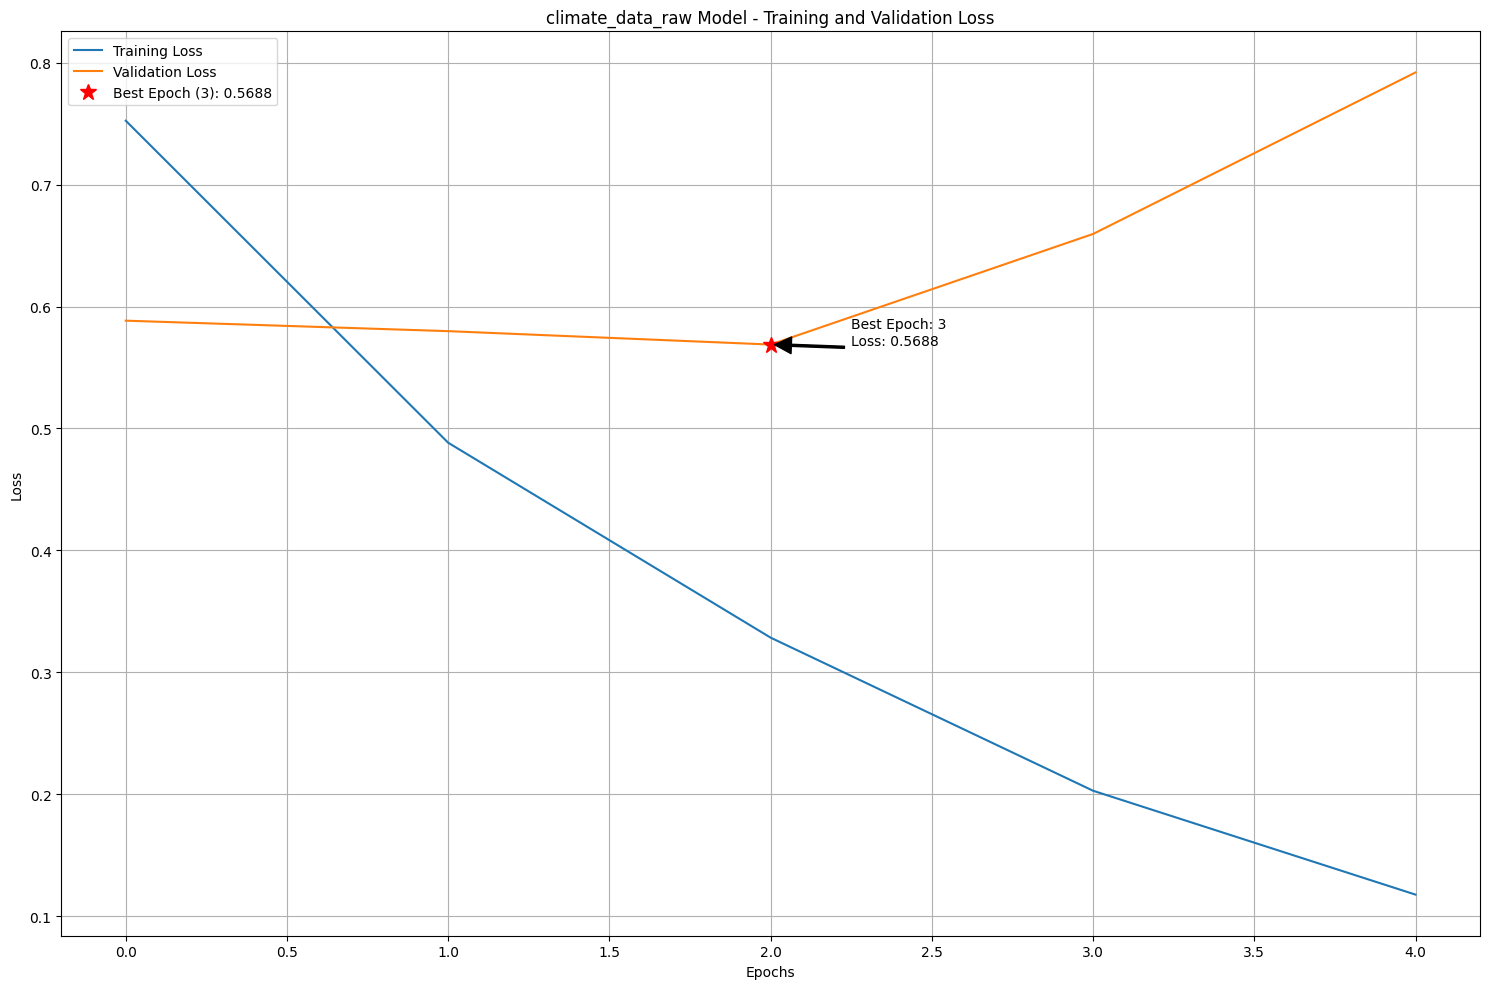

In [ ]:
# Plot training and validation loss for each model with best epoch highlighted
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10))

for i, (model_name, (train_losses, val_losses)) in enumerate(loss_history.items(), 1):
    plt.subplot(len(loss_history), 1, i)

    # Plot loss curves
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')

    # Find the best epoch (lowest validation loss)
    best_epoch = np.argmin(val_losses)
    best_val_loss = val_losses[best_epoch]

    # Highlight the best epoch with a star marker
    plt.plot(best_epoch, best_val_loss, 'r*', markersize=12,
             label=f'Best Epoch ({best_epoch+1}): {best_val_loss:.4f}')

    # Add text annotation for clarity - using offset to avoid overlapping
    # Calculate text position to avoid overlapping with the curve
    text_x = best_epoch + len(val_losses) * 0.05  # Offset by 5% of total epochs
    text_y = best_val_loss

    # Make sure text stays within plot boundaries
    text_x = min(text_x, len(val_losses) * 0.7)  # Keep within 70% of plot width

    plt.annotate(f'Best Epoch: {best_epoch+1}\nLoss: {best_val_loss:.4f}',
                xy=(best_epoch, best_val_loss),
                xytext=(text_x, text_y),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

    plt.title(f'{model_name} Model - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Print detailed information to verify
    print(f"{model_name} model - Best epoch: {best_epoch+1} with validation loss: {best_val_loss:.4f}")

plt.tight_layout()
plt.savefig('images/loss_curves_with_best_epoch.png')
plt.show()

## 3. Save the Model To Hugging Face

In [ ]:
from huggingface_hub import HfApi, login

# set up login
login()

In [ ]:
# create a model repository on Hugging Face
api = HfApi()
repo_name = "bert-large-raw-climate-sentiment-wqf7007"
api.create_repo(repo_name, exist_ok=True)

model_naem = "keanteng/bert-large-raw-climate-sentiment-wqf7007"

In [ ]:
# Push the model to Hugging Face Hub
api = HfApi()
api.upload_folder(
    folder_path=f"models/bert_climate_data_raw",
    repo_id=model_name,
    repo_type="model",
    commit_message="Upload BERT model for climate sentiment analysis",
)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

eval_results.pkl:   0%|          | 0.00/334k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/keanteng/bert-climate-sentiment-wqf7007/commit/d19d82ea0451fae7060be8ac09ae7a98a1cc24b5', commit_message='Upload BERT model for climate sentiment analysis', commit_description='', oid='d19d82ea0451fae7060be8ac09ae7a98a1cc24b5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/keanteng/bert-climate-sentiment-wqf7007', endpoint='https://huggingface.co', repo_type='model', repo_id='keanteng/bert-climate-sentiment-wqf7007'), pr_revision=None, pr_num=None)

Write model card information to the model card file. This will allow us to save the model to Hugging Face.

In [ ]:
# Add a model card with description
with open(f"README.md", "w") as f:
    f.write(r"""
---
language: en
license: agpl-3.0
datasets:
  - edqian/twitter-climate-change-sentiment-dataset
metrics:
  - accuracy
  - f1
  - precision
  - recall
base_model: bert-large-uncased
pipeline_tag: text-classification
tags:
  - text-classification
  - sentiment-analysis
  - climate-change
  - twitter
  - bert
---

# BERT Climate Sentiment Analysis Model

## Model Description
This model fine-tunes BERT (bert-large-uncased) to perform sentiment analysis on climate change-related tweets. It classifies tweets into four sentiment categories: anti-climate (negative), neutral, pro-climate (positive), and news.

## Model Details

- **Model Type:** Fine-tuned BERT (bert-large-uncased)
- **Version:** 1.0.0
- **Framework:** PyTorch & Transformers
- **Language:** English
- **License:** [AGPL-3.0](https://www.gnu.org/licenses/agpl-3.0.en.html)

## Training Data

This model was trained on the [Twitter Climate Change Sentiment Dataset](https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset/data), which contains tweets related to climate change labeled with sentiment categories:

- **news**: Factual news about climate change (2)
- **pro**: Supporting action on climate change (1)
- **neutral**: Neutral stance on climate change (0)
- **anti**: Skeptical about climate change claims (-1)

The dataset was used with raw text without special preprocessing to evaluate performance on natural language tweets.

## Training Procedure

- **Training Framework:** PyTorch with Transformers
- **Training Approach:** Fine-tuning the entire BERT model
- **Optimizer:** AdamW with learning rate 2e-5
- **Batch Size:** 64
- **Early Stopping:** Yes, with patience of 3 epochs
- **Hardware:** GPU acceleration (when available)

## Model Performance

- AUC-ROC
            
![AUC-ROC Curve](images/roc_curve.png)
            
- Training and Validation Loss

![Loss Curves](images/loss_curves_with_best_epoch.png)

## Limitations and Biases

- The model is trained on Twitter data, which may not generalize well to other text sources.
- Twitter data may contain inherent biases in how climate change is discussed.
- The model might struggle with complex or nuanced sentiment expressions.
- Sarcasm and figurative language may be misclassified.
- The model is only trained for English language content.

## Usage

```python
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/bert-large-uncased")
model = AutoModelForSequenceClassification.from_pretrained("keanteng/bert-base-climate-sentiment-wqf7007")

# Prepare text
text = "Climate change is real and we need to act now!"
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)

# Make prediction
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1)

# Map prediction to sentiment
sentiment_map = {-1: "anti", 0: "neutral", 1: "pro", 2: "news"}
predicted_sentiment = sentiment_map[predictions.item()]
print("Predicted sentiment: " + predicted_sentiment)
```

## Ethical Considerations

This model should be used responsibly for analyzing climate sentiment and should not be deployed in ways that might:
- Amplify misinformation about climate change
- Target or discriminate against specific groups
- Make critical decisions without human oversight

""")

In [ ]:
api.upload_file(
    path_or_fileobj=f"README.md",
    path_in_repo="README.md",
    repo_id=model_name,
    repo_type="model",
    commit_message="Add model card for BERT climate sentiment analysis model"
)

CommitInfo(commit_url='https://huggingface.co/keanteng/bert-climate-sentiment-wqf7007/commit/f0db00dc8da7528fcbc9bb3ad13d9e242e7965e9', commit_message='Add model card for BERT climate sentiment analysis model', commit_description='', oid='f0db00dc8da7528fcbc9bb3ad13d9e242e7965e9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/keanteng/bert-climate-sentiment-wqf7007', endpoint='https://huggingface.co', repo_type='model', repo_id='keanteng/bert-climate-sentiment-wqf7007'), pr_revision=None, pr_num=None)

Upload the images folder

In [ ]:
api.upload_folder(
    folder_path=f"images",
    repo_id=f"{model_name}",
    repo_type="model",
    path_in_repo="images",
    commit_message="Upload loss curves images"
)

CommitInfo(commit_url='https://huggingface.co/keanteng/bert-climate-sentiment-wqf7007/commit/a873a55eddc43c7e844233b64040a2d34a6807d7', commit_message='Upload loss curves images', commit_description='', oid='a873a55eddc43c7e844233b64040a2d34a6807d7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/keanteng/bert-climate-sentiment-wqf7007', endpoint='https://huggingface.co', repo_type='model', repo_id='keanteng/bert-climate-sentiment-wqf7007'), pr_revision=None, pr_num=None)

In [ ]:
api.upload_folder(
    folder_path=f"results",
    repo_id=f"{model_name}",
    repo_type="model",
    path_in_repo="results",
    commit_message="Upload AUC data"
)